In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense,Conv2D,Conv2DTranspose,Activation,
                                     Reshape,Flatten,Input,Concatenate,Dropout)
from tensorflow.keras.utils import plot_model
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
            )
    except RuntimeError as e:
        print("Error:", e)

In [88]:
def plot_imgs(imgs,gts):
    num = 8
    width_ratios = [1, 1]
    fig,axs = plt.subplots(num,2,figsize=(50,50),gridspec_kw={'width_ratios': width_ratios})
    
    for i in range(num):
        axs[i][0].imshow(imgs[i][:, :, ::-1])
        axs[i][0].set_aspect('equal')
        axs[i][1].imshow(gts[i],cmap='gray')
        axs[i][1].set_aspect('equal')
        

In [51]:
dict_path = "D:/Medical image processing/"

train_img_path = "ISBI2016_ISIC_Part1_Training_Data/"
train_gt_path = "ISBI2016_ISIC_Part1_Training_GroundTruth/"
img_name_lst = np.array(os.listdir(dict_path+img_path))

test_img_path = 'ISBI2016_ISIC_Part1_Test_Data/'
test_gt_path = 'ISBI2016_ISIC_Part1_Test_GroundTruth/'
test_img_name_lst = np.array(os.listdir(dict_path+test_img_path))



def create_batch(batch_size=32,train=True):
    img_batch = []
    gt_batch = []
    
    if(train==True):
        img_idx = np.random.randint(0,len(img_name_lst),(batch_size))
        get_batch_names = img_name_lst[img_idx]
        img_path = train_img_path
        gt_path = train_gt_path
        
    if(train==False):
        print('Getting images for testing')
        img_idx = np.random.randint(0,len(test_img_name_lst),(batch_size))
        get_batch_names = test_img_name_lst[img_idx]
        batch_size = 8
        img_path = test_img_path
        gt_path = test_gt_path
        
    
    for i in range(batch_size):
        img = cv2.imread(dict_path + img_path + get_batch_names[i])
        img = cv2.resize(img,(256,256))
        gt = cv2.imread(dict_path + gt_path + get_batch_names[i][:-4] + '_Segmentation.png')
        gt = cv2.resize(gt,(256,256))
        gt = cv2.cvtColor(gt,cv2.COLOR_BGR2GRAY)
        gt = np.expand_dims(gt,axis=-1)
        img_batch.append(img)
        gt_batch.append(gt)
        
        
    return np.array(img_batch)/255.0,np.array(gt_batch)/255.0
        

    

In [10]:
def create_unet():
    
    in_lyr = Input(shape=(256,256,3))
    lyr_1 = Conv2D(1,kernel_size=3,strides=1,padding='same',name='layer1')(in_lyr)
    act_1 = Activation('relu')(lyr_1)
    filters = [32,64,124]

    #..................................................................................

    lyr_2 = Conv2D(filters[0],kernel_size=3,strides=1,padding='same',name='layer2')(act_1)
    act_2 = Activation('relu')(lyr_2)

    lyr_3 = Conv2D(filters[0],kernel_size=3,strides=1,padding='same',name='layer3')(act_2)
    act_3 = Activation('relu')(lyr_3)

    #............................................................................................

    lyr_4 = Conv2D(filters[0],kernel_size=3,strides=2,padding='same',name='layer4')(act_3)
    act_4 = Activation('relu')(lyr_4)

    lyr_5 = Conv2D(filters[1],kernel_size=3,strides=1,padding='same',name='layer5')(act_4)
    act_5 = Activation('relu')(lyr_5)

    lyr_6 = Conv2D(filters[1],kernel_size=3,strides=1,padding='same',name='layer6')(act_5)
    act_6 = Activation('relu')(lyr_6)

    #........................................................................................................

    lyr_7 = Conv2D(filters[1],kernel_size=3,strides=2,padding='same',name='layer7')(act_6)
    act_7 = Activation('relu')(lyr_7)

    lyr_8 = Conv2D(filters[2],kernel_size=3,strides=1,padding='same',name='layer8')(act_7)
    act_8 = Activation('relu')(lyr_8)

    lyr_9 = Conv2D(filters[2],kernel_size=3,strides=1,padding='same')(act_8)
    act_9 = Activation('relu')(lyr_9)

    #.............................Middle...............................................................

    lyr_10 = Conv2D(filters[2],kernel_size=3,strides=2,padding='same',name='layer9')(act_9)
    act_10 = Activation('relu')(lyr_10)

    lyr_11 = Conv2D(filters[2],kernel_size=3,strides=1,padding='same',name='layer10')(act_10)
    act_11 = Activation('relu')(lyr_11)

    lyr_12= Conv2D(filters[2],kernel_size=3,strides=1,padding='same')(act_11)
    act_12 = Activation('relu')(lyr_12)


    #.....................UP.......................................................................

    lyr_13 = Conv2DTranspose(filters[2],kernel_size=3,strides=2,padding='same')(act_12)
    act_13 = Activation('relu')(lyr_13)

    cat_lyr_1 = Concatenate(axis=-1)([act_9,act_13])

    lyr_14 = Conv2DTranspose(filters[1],kernel_size=3,strides=1,padding='same')(cat_lyr_1)
    act_14 = Activation('relu')(lyr_14)

    lyr_15 = Conv2DTranspose(filters[1],kernel_size=3,strides=1,padding='same')(act_14)
    act_15 = Activation('relu')(lyr_15)

    #.....................................................................................................

    lyr_16 = Conv2DTranspose(filters[1],kernel_size=3,strides=2,padding='same')(act_15)
    act_16 = Activation('relu')(lyr_16)

    cat_lyr_2 = Concatenate(axis=-1)([act_6,act_16])

    lyr_17 = Conv2DTranspose(filters[0],kernel_size=3,strides=1,padding='same')(cat_lyr_2)
    act_17 = Activation('relu')(lyr_17)

    lyr_18 = Conv2DTranspose(filters[0],kernel_size=3,strides=1,padding='same')(act_17)
    act_18 = Activation('relu')(lyr_18)

    #.....................................................................................................
    lyr_19 = Conv2DTranspose(filters[0],kernel_size=3,strides=2,padding='same')(lyr_18)
    act_19 = Activation('relu')(lyr_19)

    cat_lyr_3 = Concatenate(axis=-1)([act_3,act_19])
  

    lyr_20 = Conv2DTranspose(filters[0],kernel_size=3,strides=1,padding='same')(cat_lyr_3)
    act_20 = Activation('relu')(lyr_20)

    lyr_21 = Conv2DTranspose(filters[0],kernel_size=3,strides=1,padding='same')(act_20)
    act_21 = Activation('relu')(lyr_21)

    #.....................................................................................................

    lyr_22 = Conv2DTranspose(1,kernel_size=3,strides=1,padding='same')(act_21)
    out_lyr = Activation('sigmoid')(lyr_22)


    model = tf.keras.Model(inputs=in_lyr,outputs=out_lyr)
    return model


In [52]:
model = create_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

def train_model(epochs=5,batch_size=8):
    for i in range(epochs):
        imgs,gts = create_batch(batch_size)
        loss,acc = model.train_on_batch(x=imgs,y=gts)   #,validation_data=(val_imgs,val_gts)
        if(i%5==0):
            print(i," loss: ",loss," accuracy: ",acc)

In [53]:
train_model(epochs=25,batch_size=16)

0  loss:  0.7038612961769104  accuracy:  0.22713947296142578
5  loss:  0.5326090455055237  accuracy:  0.7437047958374023
10  loss:  0.5536792874336243  accuracy:  0.7302427291870117
15  loss:  0.5979106426239014  accuracy:  0.7056818008422852
20  loss:  0.6140208840370178  accuracy:  0.6526145935058594


In [54]:
test_imgs,test_gts = create_batch(8,train=False)
pred_gts = model.predict(test_imgs)

Getting images for testing


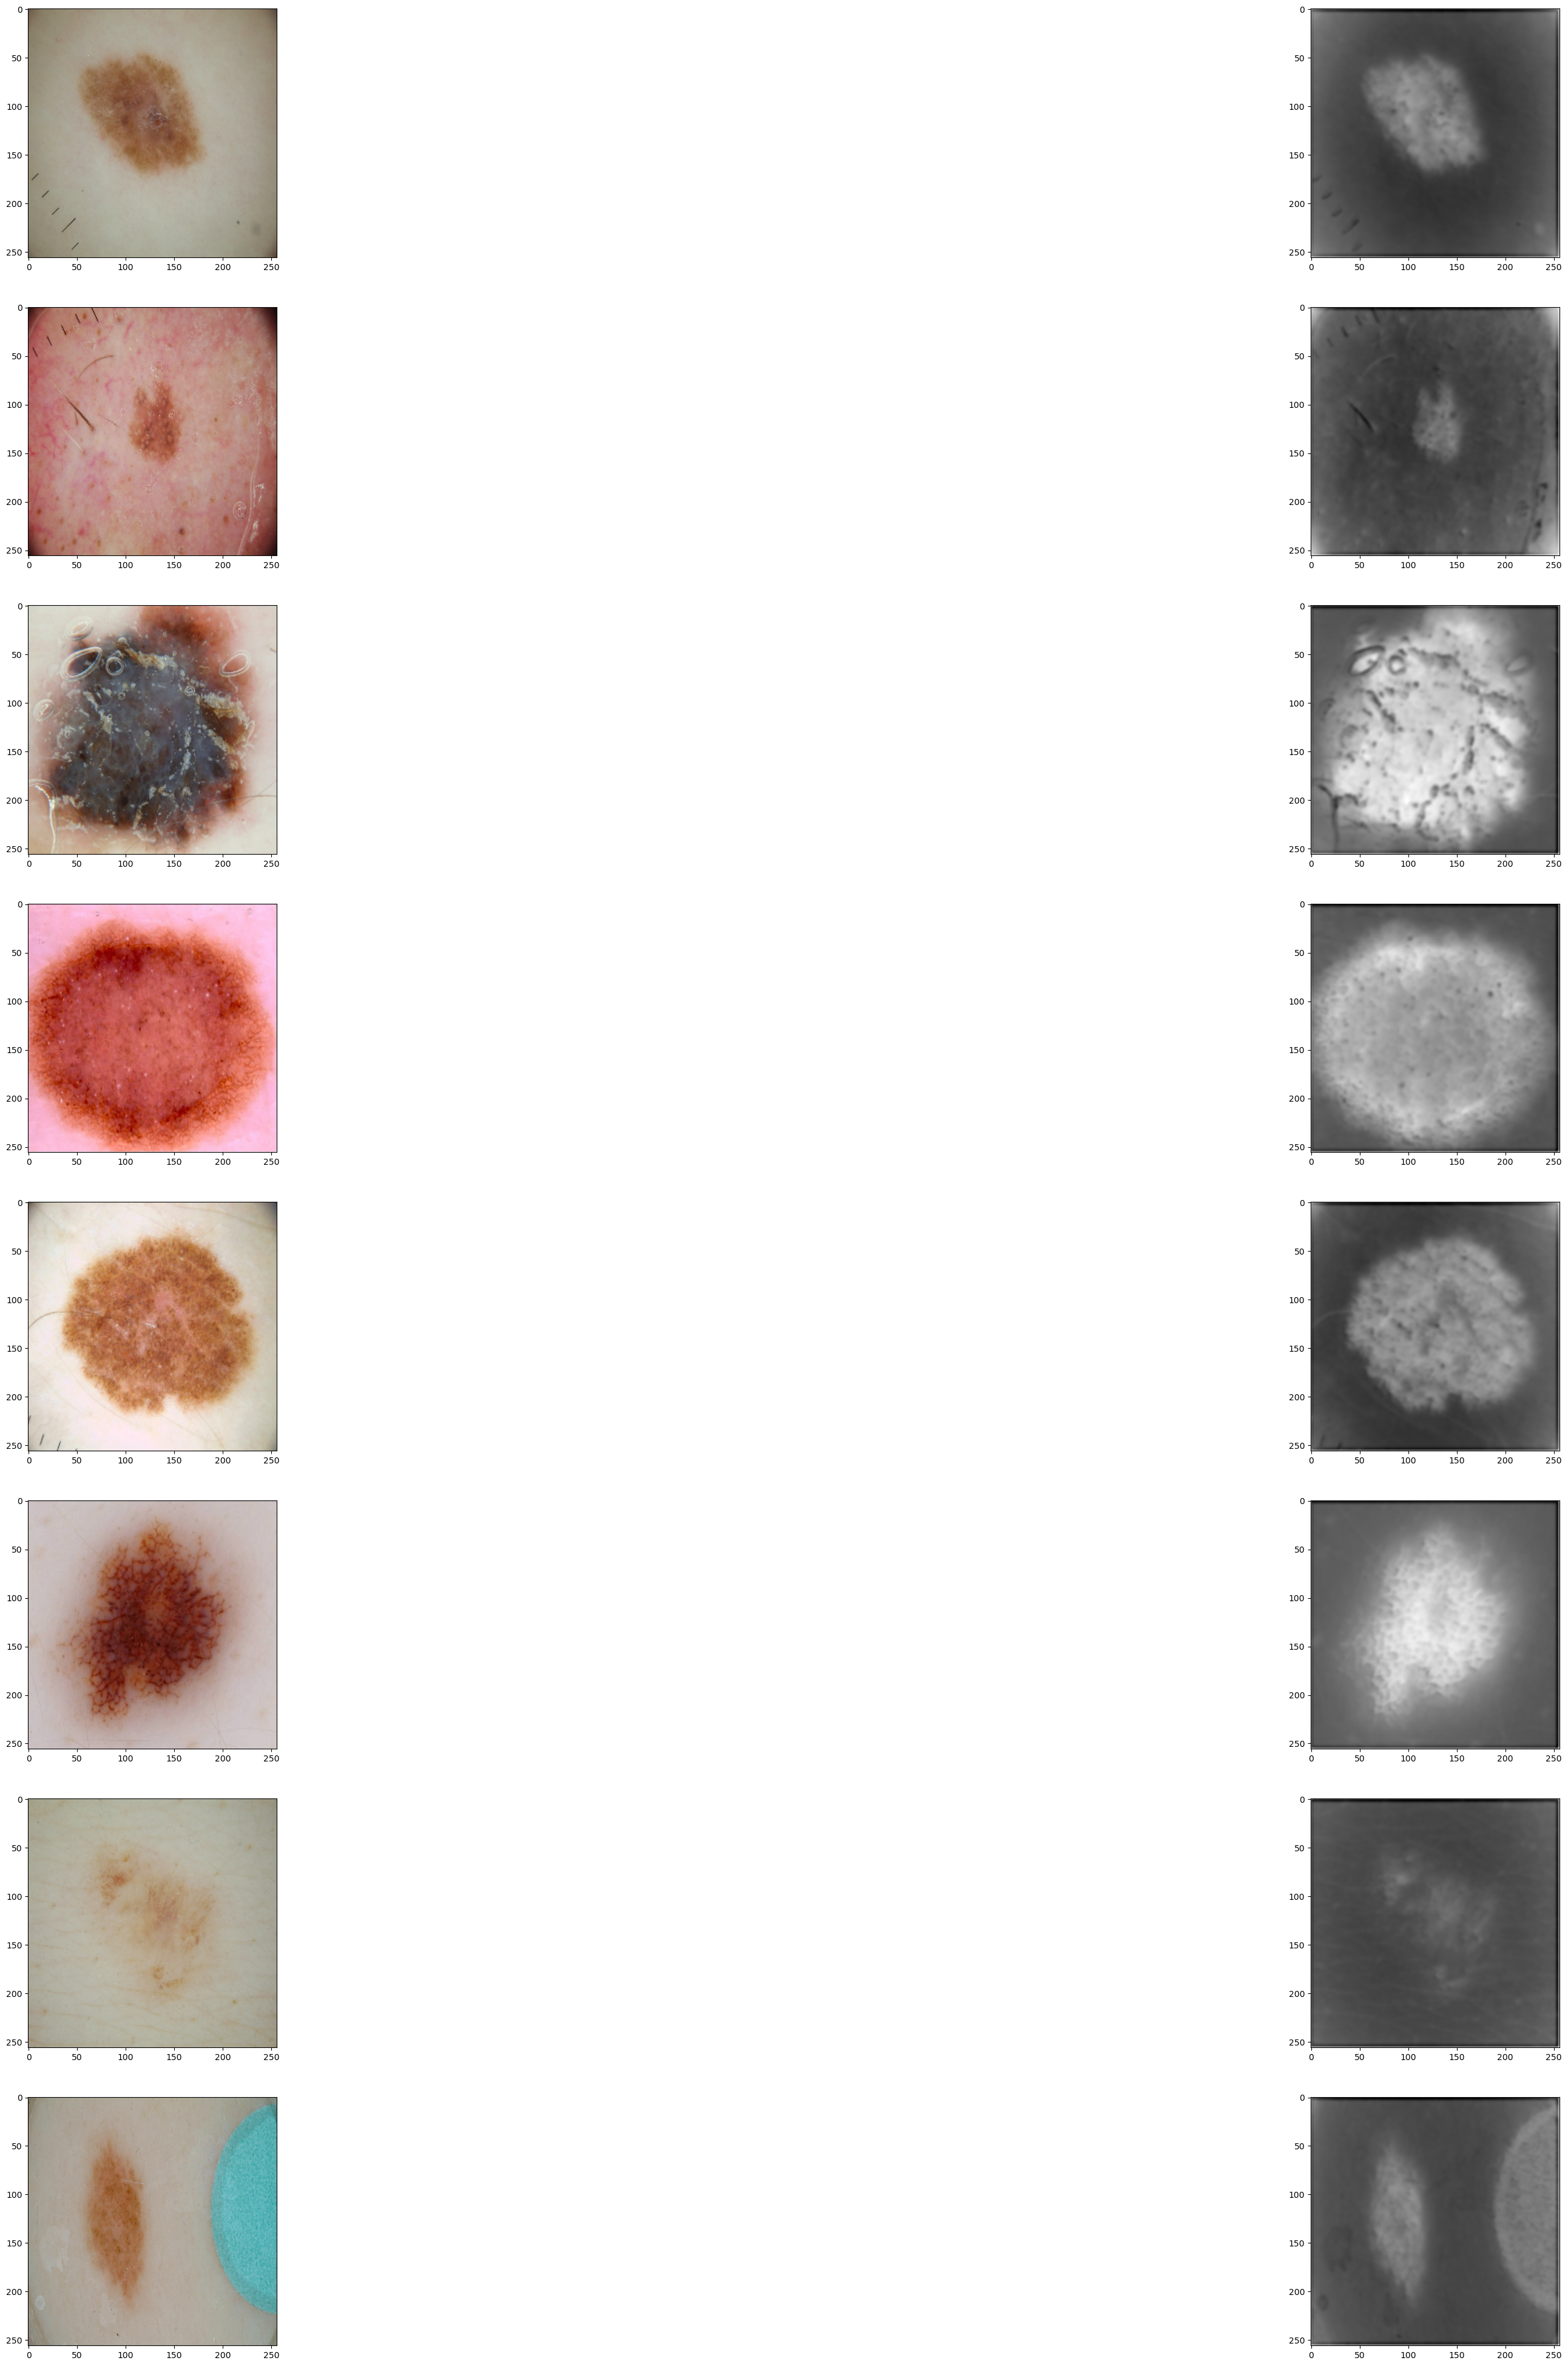

In [89]:
plot_imgs(test_imgs,pred_gts)